# Cats vs Dogs Image Classification Project
---

## Dataset Download

To get started with the Cats vs. Dogs image classification project, you need to download the dataset. Follow these steps:

**1. Download the dataset from Kaggle:**
   - Visit the [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats/data) page.
   - Download the zip file containing the images of cats and dogs.

**2. Extract the contents of the zip file:**
   - After downloading, extract the contents of the zip file to your desired location on your local machine.

**3. Update the base directory in your code:**
   - Ensure you update the path to the base directory in your code to reflect the location where you extracted the dataset.

Here's an example of how you might update the path in your code:

```python
import os

# Update this path to the location where you extracted the dataset
base_dir = '/path/to/your/dataset/directory'
```

Make sure to replace `'/path/to/your/dataset/directory'` with the actual path on your machine.

By following these steps, you will have the dataset ready for use in your image classification project.

## Download Model Weights in the Sandbox Environment

To download model weights, follow these steps:

1. Create a directory for the models:
   ```bash
   mkdir -p models
   wget -P models https://github.com/MicrosoftDocs/pytorchfundamentals/raw/main/computer-vision-pytorch/vgg16-397923af.pth
   ```
2. After successfully downloading, your file structure should have a models folder containing the vgg16-397923af.pth file.

## Introduction

This project focuses on classifying images of cats and dogs using a Convolutional Neural Network (CNN) built with PyTorch. The dataset used is the well-known Dogs vs. Cats dataset from Kaggle. The main steps involved in this project include data preprocessing, model building, training, and evaluation.

In [1]:
from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir
from torchinfo import summary
import json, requests
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
# Define paths
base_dir = '/Users/tayalarajan.tr/Documents/Online Courses/PyTorch/Cats vs. Dogs Dataset/dogs-vs-cats/train'
dogs_dir = os.path.join(base_dir, 'dogs')
cats_dir = os.path.join(base_dir, 'cats')

# Create directories if they don't exist
os.makedirs(dogs_dir, exist_ok=True)
os.makedirs(cats_dir, exist_ok=True)

# Move files into respective directories
for filename in os.listdir(base_dir):
    if filename.startswith('dog') and not os.path.isdir(os.path.join(base_dir, filename)):
        shutil.move(os.path.join(base_dir, filename), os.path.join(dogs_dir, filename))
    elif filename.startswith('cat') and not os.path.isdir(os.path.join(base_dir, filename)):
        shutil.move(os.path.join(base_dir, filename), os.path.join(cats_dir, filename))

print("Files organized successfully!")

Files organized successfully!


### 1. Data Preprocessing
- **Normalization:** Images are normalized using the mean and standard deviation of the ImageNet dataset.
- **Transforms:** The images are resized and cropped to a consistent size, and then converted to tensors.

In [3]:
# Define the normalization transform
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])

### 2. Data Loading
- **Dataset:** The dataset is loaded using the `ImageFolder` class from `torchvision.datasets`.

In [4]:
# Correct the path to the dataset
dataset_path = '/Users/tayalarajan.tr/Documents/Online Courses/PyTorch/Cats vs. Dogs Dataset/dogs-vs-cats/train'
dataset = datasets.ImageFolder(dataset_path, transform=trans)

# Split the dataset into training and testing sets
trainset, testset = torch.utils.data.random_split(dataset, [20000, len(dataset) - 20000])

# Example function to display dataset information (if needed)
def display_dataset(dataset):
    print(f"Number of images: {len(dataset)}")
    classes = dataset.classes
    print(f"Classes: {classes}")
    for class_name in classes:
        print(f"Number of images in class {class_name}: {sum([1 for _, label in dataset if dataset.classes[label] == class_name])}")

# Display dataset information
display_dataset(dataset)


Number of images: 25000
Classes: ['cats', 'dogs']
Number of images in class cats: 12500
Number of images in class dogs: 12500


- **DataLoader:** The data is split into training and testing sets and loaded into a DataLoader for batching and shuffling.

In [5]:
# Create DataLoader for training and testing
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


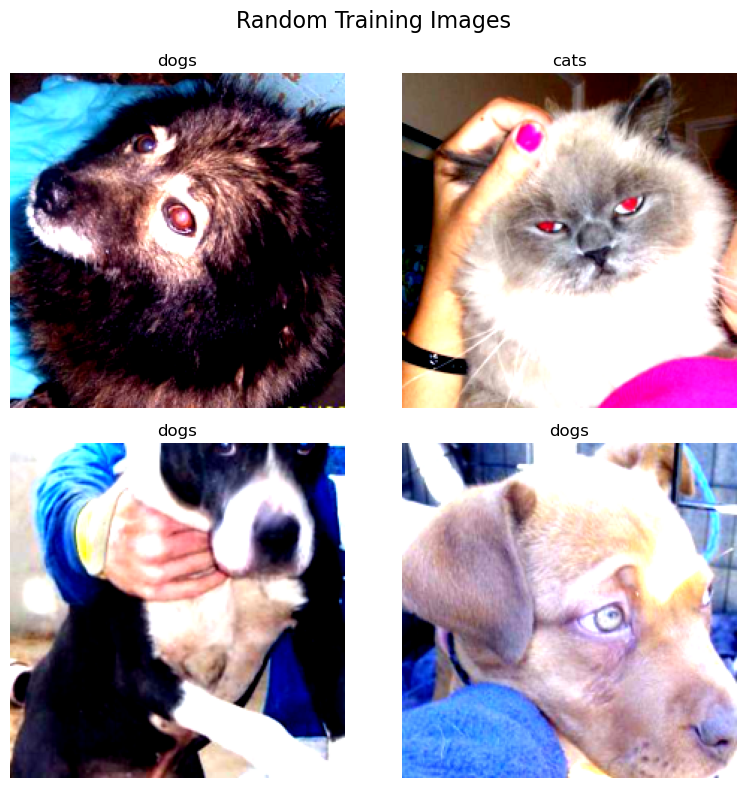

In [6]:
# Function to show an image with title
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Random Training Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    img = images[i] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f'{dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### 3. Model Building
- **VGG Model:** A pre-trained VGG model is used as the feature extractor, with its classifier modified to output two classes (cat and dog).
- **Freezing Layers:** The parameters of the feature extractor are frozen to prevent them from being updated during training.

In [7]:
model_dir = 'models'
model_path = os.path.join(model_dir, 'vgg16-397923af.pth')

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

In [8]:
file_path = 'models/vgg16-397923af.pth'

vgg = torchvision.models.vgg16()
vgg.load_state_dict(torch.load(file_path))
vgg.eval()

sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


In [9]:
class_map = json.loads(requests.get("https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [10]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cpu


tensor(282)

torch.Size([1, 512, 7, 7])


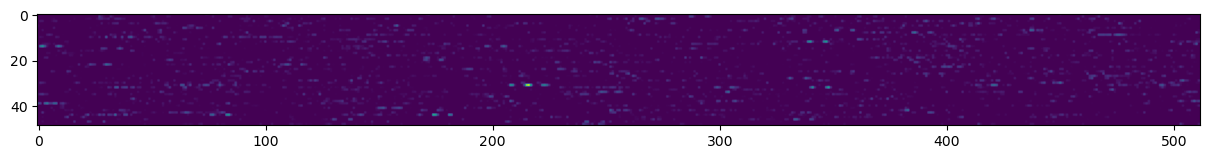

In [12]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

In [13]:
bs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs * 100
feature_tensor = torch.zeros(num, 512 * 7 * 7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x, l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs, -1)
        label_tensor[i:i+bs] = l
    i += bs
    print('.', end='')
    if i >= num:
        break


....................................................................................................

In [14]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.890, Val acc=0.980, Train loss=0.144, Val loss=0.014
Epoch  1, Train acc=0.989, Val acc=0.980, Train loss=0.005, Val loss=0.004
Epoch  2, Train acc=0.997, Val acc=1.000, Train loss=0.001, Val loss=0.000


/Users/tayalarajan.tr/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch  3, Train acc=0.997, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.004
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.004
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.004
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.004
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.004


In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

### 4. Training
- **Optimizer and Loss Function:** The Adam optimizer and cross-entropy loss function are used for training the model.
- **Training Loop:** The model is trained over multiple epochs, and the loss and accuracy are recorded.


In [17]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.5, train loss = 0.052305981516838074
Epoch 0, minibatch 90: train acc = 0.9478021978021978, train loss = 0.1007334216610416
Epoch 0, minibatch 180: train acc = 0.9592541436464088, train loss = 0.09373864021090512
Epoch 0, minibatch 270: train acc = 0.9612546125461254, train loss = 0.11124588378681027
Epoch 0, minibatch 360: train acc = 0.9638157894736842, train loss = 0.12045837571416206
Epoch 0, minibatch 450: train acc = 0.9659090909090909, train loss = 0.12554857207507622
Epoch 0, minibatch 540: train acc = 0.9678835489833642, train loss = 0.1303025561207544
Epoch 0, minibatch 630: train acc = 0.9688985736925515, train loss = 0.13907549536171504
Epoch 0, minibatch 720: train acc = 0.9693134535367545, train loss = 0.14231344532536733
Epoch 0, minibatch 810: train acc = 0.970098643649815, train loss = 0.1425097520783562
Epoch 0, minibatch 900: train acc = 0.9710044395116537, train loss = 0.14227764032260162
Epoch 0, minibatch 990: train acc = 0.9710

## Conclusion

The VGG model, pre-trained on ImageNet, performs well on the Dogs vs. Cats dataset with minor modifications. The project demonstrates the effectiveness of transfer learning and the importance of freezing pre-trained layers for efficient training.

## Learnings

- **Transfer Learning:** Using pre-trained models can significantly speed up the training process and improve accuracy, especially with limited data.
- **Data Augmentation:** Proper data preprocessing and augmentation are crucial for training robust models.
- **PyTorch:** Understanding the basics of PyTorch, including DataLoader, model building, and training loops, is essential for deep learning projects.
- **Model Evaluation:** Regular evaluation and visualization of model performance help in diagnosing issues and improving the model.